### Exploratory Descriptive Analysis 
#### Top 5 Wine-producing countries, provinces and histogram of prices and ratings

data shape after preprocessing (73637, 9)


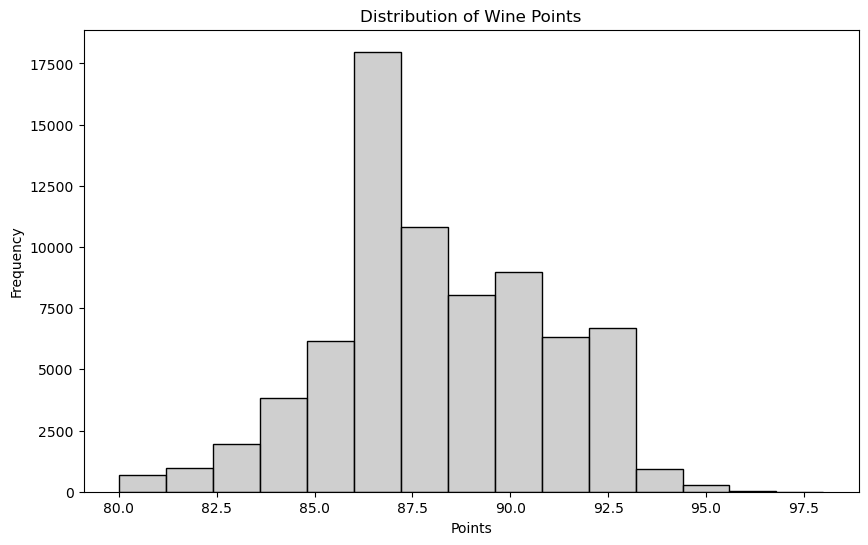

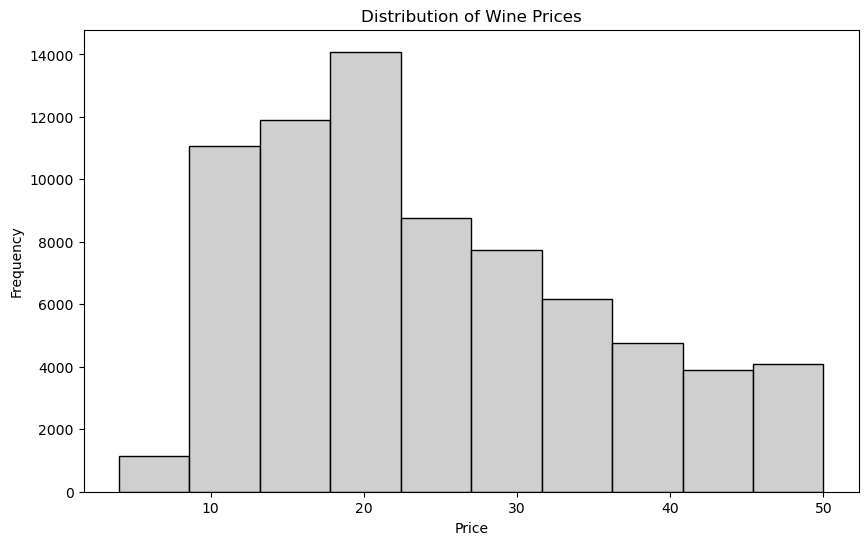

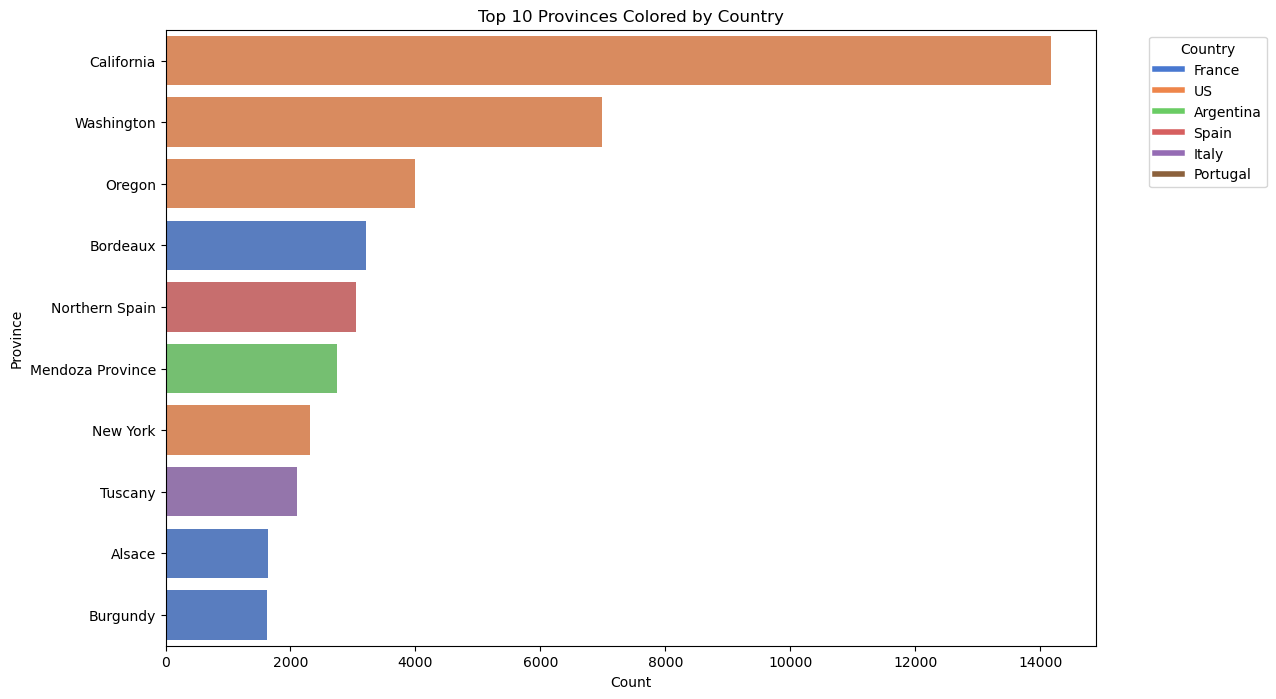

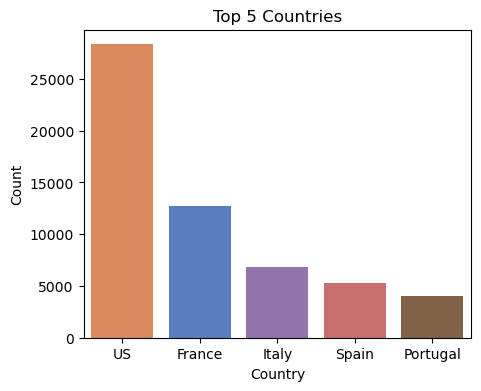

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Load the data
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
save_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/plots_figures/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data.csv')

# Filter out wines with a price > 50
wine_data_low = wine_data.loc[wine_data.price <= 50]
wine_data_low.to_csv(file_path + 'cleaned_wine_data_price_max=50.csv', index=False)
print('data shape after preprocessing', wine_data_low.shape)

# Summary statistics
summary_stats = wine_data_low.describe(include='all')
#print("data summary", summary_stats)

# Distribution of wine points
plt.figure(figsize=(10, 6))
sns.histplot(wine_data_low['points'], bins=15, color="silver")
plt.title('Distribution of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.savefig(save_path + 'distribution_wine_points.png', bbox_inches='tight')
plt.show()

# Distribution of wine prices
plt.figure(figsize=(10, 6))
sns.histplot(wine_data_low['price'], bins=10, color="silver")
plt.title('Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig(save_path + 'distribution_wine_prices.png', bbox_inches='tight')
plt.show()

# Top 10 provinces colored by Country 
top_provinces = wine_data_low['province'].value_counts().head(10).index
filtered_data = wine_data_low[wine_data_low['province'].isin(top_provinces)]
province_country_map = filtered_data.groupby('province')['country'].first().to_dict()
province_counts = wine_data_low['province'].value_counts().loc[top_provinces]

# Set a color palette for Countries for both plots
top_countries_in_provinces = list(province_country_map.values())
top_countries = wine_data_low['country'].value_counts().head(5).index
unique_countries = pd.unique(top_countries_in_provinces + list(top_countries))
color_palette = sns.color_palette("muted", len(unique_countries))
country_color_map = dict(zip(unique_countries, color_palette))

# Apply the color mapping to the provinces
province_colors = [country_color_map[province_country_map[province]] for province in province_counts.index]
plt.figure(figsize=(12, 8))
sns.barplot(y=province_counts.index, x=province_counts.values, palette=province_colors)
plt.title('Top 10 Provinces Colored by Country')
plt.xlabel('Count')
plt.ylabel('Province')

# Create a custom legend
handles = [plt.Line2D([0], [0], color=country_color_map[country], lw=4) for country in unique_countries]
plt.legend(handles, unique_countries, title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(save_path + 'top_provinces_by_country.png', bbox_inches='tight')
plt.show()

# Plotting the top 5 countries with matching colors
plt.figure(figsize=(5, 4))
sns.barplot(x=top_countries, y=wine_data_low['country'].value_counts().loc[top_countries], 
            palette=[country_color_map[country] for country in top_countries])
plt.title('Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.savefig(save_path + 'top_5_countries.png', bbox_inches='tight')
plt.show()


### First analysis on the relationship between Prices & Ratings
#### Entire dataset + Country-specific insights

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                 2.804e+04
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:28:27   Log-Likelihood:            -1.6710e+05
No. Observations:               73631   AIC:                         3.342e+05
Df Residuals:                   73629   BIC:                         3.342e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.8776      0.021   4105.775      0.0

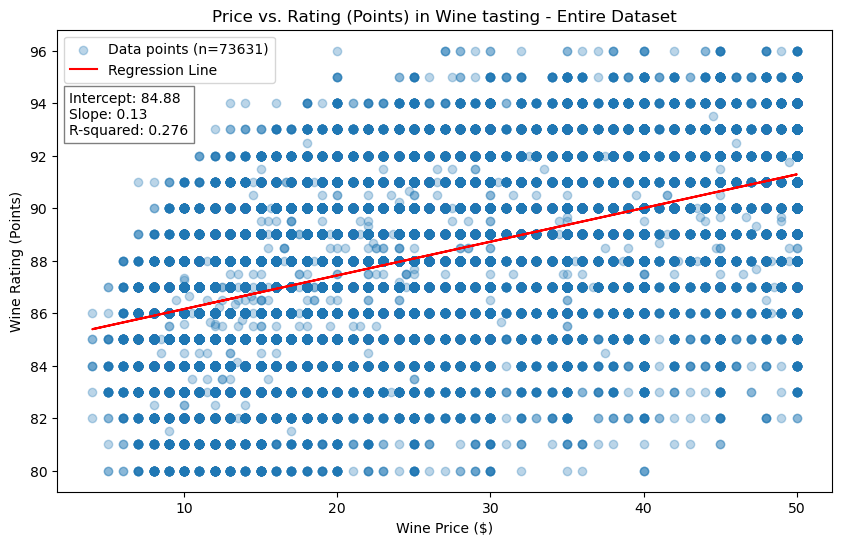

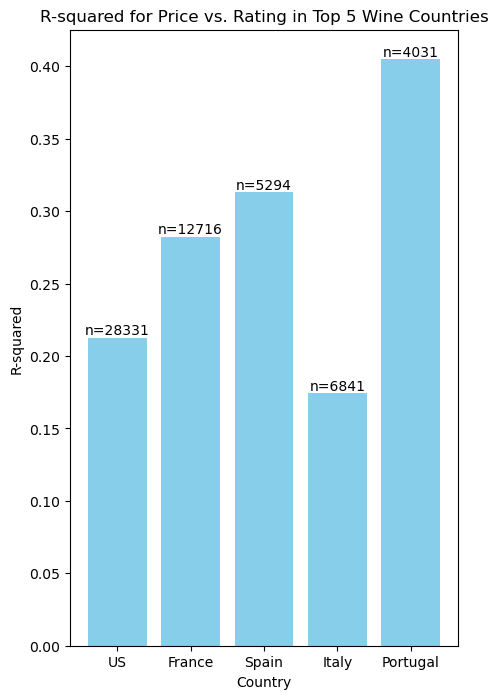

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
save_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/plots_figures/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv')

# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

# Remove outliers from the data
columns_to_check = ['price', 'points']
cleaned_wine_data = remove_outliers(wine_data, columns_to_check)

# Define top 5 wine-producing countries
top_5_countries = ['US', 'France', 'Spain', 'Italy', 'Portugal']

### 1. Run linear regression for the entire dataset without breakpoint and rolling average ###
X = cleaned_wine_data[['price']]
y = cleaned_wine_data['points']
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Summary of the model
model_summary = model.summary()
print(model_summary)

# Get number of data points
n_total = len(cleaned_wine_data)

# Plot linear regression without rolling average or breakpoint
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_wine_data['price'], cleaned_wine_data['points'], alpha=0.3, label=f'Data points (n={n_total})')
plt.plot(cleaned_wine_data['price'], model.predict(sm.add_constant(cleaned_wine_data[['price']])), color='red', label='Regression Line')

# Display the regression statistics on the plot
slope = model.params['price']
intercept = model.params['const']
r_squared = model.rsquared
stats_text = f'Intercept: {intercept:.2f}\nSlope: {slope:.2f}\nR-squared: {r_squared:.3f}'
plt.text(max(cleaned_wine_data['price']) * 0.05, min(cleaned_wine_data['points']) * 1.16, stats_text,
         bbox=dict(facecolor='white', alpha=0.5), fontsize=10)

plt.title('Price vs. Rating (Points) in Wine tasting - Entire Dataset')
plt.xlabel('Wine Price ($)')
plt.ylabel('Wine Rating (Points)')
plt.legend()

# Save the plot without grid
plt.savefig(save_path + 'price_vs_rating_entire_dataset.png')
plt.show()

### 2. Run linear regression for each of the top 5 countries and plot R-squared for each ###
r_squared_dict = {}
n_points_dict = {}

for country in top_5_countries:
    country_data = cleaned_wine_data[cleaned_wine_data['country'] == country]
    X_country = sm.add_constant(country_data[['price']])
    y_country = country_data['points']
    
    # Fit the linear regression model for the country
    model_country = sm.OLS(y_country, X_country).fit()
    
    # Store R-squared value and number of data points
    r_squared_dict[country] = model_country.rsquared
    n_points_dict[country] = len(country_data)

# Plot R-squared for each country with number of data points
plt.figure(figsize=(5, 8))
bars = plt.bar(r_squared_dict.keys(), r_squared_dict.values(), color='skyblue')
plt.title('R-squared for Price vs. Rating in Top 5 Wine Countries')
plt.xlabel('Country')
plt.ylabel('R-squared')

# Add the number of data points on top of each bar
for bar, country in zip(bars, top_5_countries):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'n={n_points_dict[country]}', 
             ha='center', va='bottom', fontsize=10)

# Save the plot without grid
plt.savefig(save_path + 'r_squared_top_5_countries.png')
plt.show()


Entire Dataset Breakpoint: $33.74
Slope before breakpoint: 0.18
Slope after breakpoint: 0.07
T-statistic for slope comparison: 27.28
P-value for slope comparison: 0.0000
The slopes before and after the breakpoint are significantly different.


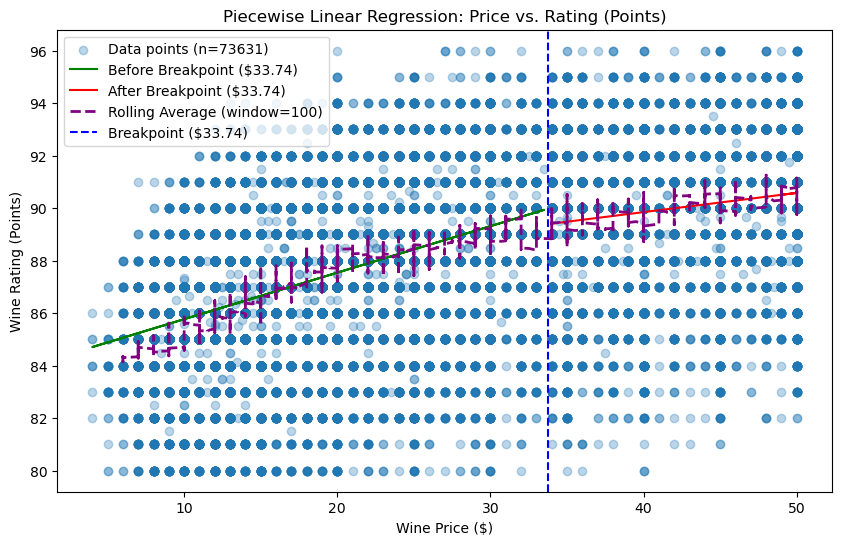

US Price Breakpoint: $46.75
Slope before breakpoint: 0.11
Slope after breakpoint: -0.09
T-statistic: 3.80, P-value: 0.0001
The slopes before and after the breakpoint are significantly different.

France Price Breakpoint: $33.64
Slope before breakpoint: 0.19
Slope after breakpoint: 0.05
T-statistic: 14.23, P-value: 0.0000
The slopes before and after the breakpoint are significantly different.

Italy Price Breakpoint: $31.78
Slope before breakpoint: 0.14
Slope after breakpoint: 0.04
T-statistic: 10.26, P-value: 0.0000
The slopes before and after the breakpoint are significantly different.

Spain Price Breakpoint: $32.81
Slope before breakpoint: 0.21
Slope after breakpoint: 0.08
T-statistic: 6.77, P-value: 0.0000
The slopes before and after the breakpoint are significantly different.

Portugal Price Breakpoint: $28.64
Slope before breakpoint: 0.26
Slope after breakpoint: 0.08
T-statistic: 12.34, P-value: 0.0000
The slopes before and after the breakpoint are significantly different.

    C

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Load the dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
save_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/plots_figures/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv')

# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

# Remove outliers from the data
columns_to_check = ['price', 'points']
cleaned_wine_data = remove_outliers(wine_data, columns_to_check)

### 1. Function to perform piecewise linear regression ###
def piecewise_linear_fit(df, x_col, y_col, breakpoint):
    df_copy = df.copy()  # Create a deep copy to avoid the warning
    
    # Create new piecewise predictor variable
    df_copy.loc[:, 'x_piecewise'] = np.where(df_copy[x_col] <= breakpoint, df_copy[x_col], breakpoint)
    
    # Separate into before and after breakpoint
    df_before = df_copy[df_copy[x_col] <= breakpoint].copy()  
    df_after = df_copy[df_copy[x_col] > breakpoint].copy()  
    
    # Model before breakpoint
    X_before = sm.add_constant(df_before[['x_piecewise']])
    y_before = df_before[y_col]
    model_before = sm.OLS(y_before, X_before).fit()
    
    # Model after breakpoint
    df_after.loc[:, 'x_piecewise'] = df_after[x_col] - breakpoint  # Shift for the after-breakpoint slope
    X_after = sm.add_constant(df_after[['x_piecewise']])  
    y_after = df_after[y_col]
    model_after = sm.OLS(y_after, X_after).fit()

    return model_before, model_after

### 2. Function to evaluate if slopes differ statistically ###
def compare_slopes(model_before, model_after):
    slope_before = model_before.params['x_piecewise']
    slope_after = model_after.params['x_piecewise']
    
    # Compute standard errors for the slopes
    se_before = model_before.bse['x_piecewise']
    se_after = model_after.bse['x_piecewise']
    
    # T-test to compare the slopes
    t_stat = (slope_before - slope_after) / np.sqrt(se_before**2 + se_after**2)
    df = len(model_before.resid) + len(model_after.resid) - 4  
    
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=df))
    
    return t_stat, p_value, slope_before, slope_after

### 3. Function to find the breakpoint ###
def find_breakpoint(df, x_col, y_col):
    breakpoints = np.linspace(df[x_col].min(), df[x_col].max(), 100)
    best_breakpoint = None
    best_r_squared = -np.inf

    for breakpoint in breakpoints:
        df_copy = df.copy()  
        df_copy.loc[:, 'x_piecewise'] = np.where(df_copy[x_col] <= breakpoint, df_copy[x_col], breakpoint)
        X_piecewise = df_copy[['x_piecewise']]
        X_piecewise = sm.add_constant(X_piecewise)
        y = df_copy[y_col]
        
        model_piecewise = sm.OLS(y, X_piecewise).fit()
        
        if model_piecewise.rsquared > best_r_squared:
            best_r_squared = model_piecewise.rsquared
            best_breakpoint = breakpoint
            
    return best_breakpoint, best_r_squared

### 4. Perform analysis on the entire dataset ###

# Find the breakpoint for the entire dataset
price_rating_breakpoint, _ = find_breakpoint(cleaned_wine_data, 'price', 'points')

# Perform piecewise linear regression
model_before, model_after = piecewise_linear_fit(cleaned_wine_data, 'price', 'points', price_rating_breakpoint)

# Compare the slopes before and after the breakpoint
t_stat, p_value, slope_before, slope_after = compare_slopes(model_before, model_after)

# Print results for the entire dataset
print(f"Entire Dataset Breakpoint: ${price_rating_breakpoint:.2f}")
print(f"Slope before breakpoint: {slope_before:.2f}")
print(f"Slope after breakpoint: {slope_after:.2f}")
print(f"T-statistic for slope comparison: {t_stat:.2f}")
print(f"P-value for slope comparison: {p_value:.4f}")
if p_value < 0.05:
    print("The slopes before and after the breakpoint are significantly different.")
else:
    print("The slopes before and after the breakpoint are not significantly different.")

### 5. Plot piecewise regression for the entire dataset ###
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_wine_data['price'], cleaned_wine_data['points'], alpha=0.3, label=f'Data points (n={len(cleaned_wine_data)})')

# Plot the regression lines before and after the breakpoint
X_plot_before = sm.add_constant(cleaned_wine_data[cleaned_wine_data['price'] <= price_rating_breakpoint][['price']])
plt.plot(cleaned_wine_data[cleaned_wine_data['price'] <= price_rating_breakpoint]['price'],
         model_before.predict(X_plot_before), color='green', label=f'Before Breakpoint (${price_rating_breakpoint:.2f})')

X_plot_after = sm.add_constant(cleaned_wine_data[cleaned_wine_data['price'] > price_rating_breakpoint][['price']])
X_plot_after['x_piecewise'] = X_plot_after['price'] - price_rating_breakpoint
X_plot_after = X_plot_after[['const', 'x_piecewise']]

plt.plot(cleaned_wine_data[cleaned_wine_data['price'] > price_rating_breakpoint]['price'],
         model_after.predict(X_plot_after), color='red', label=f'After Breakpoint (${price_rating_breakpoint:.2f})')

# Rolling average
cleaned_data_sorted_by_price = cleaned_wine_data.sort_values(by='price')
cleaned_price_roll_mean = cleaned_data_sorted_by_price['points'].rolling(window=100).mean()
plt.plot(cleaned_data_sorted_by_price['price'], cleaned_price_roll_mean, color='purple', linewidth=2, label='Rolling Average (window=100)', linestyle='--')

plt.axvline(x=price_rating_breakpoint, color='blue', linestyle='--', label=f'Breakpoint (${price_rating_breakpoint:.2f})')
plt.title('Piecewise Linear Regression: Price vs. Rating (Points)')
plt.xlabel('Wine Price ($)')
plt.ylabel('Wine Rating (Points)')
plt.legend()
plt.savefig(save_path + 'price_vs_rating_piecewise_regression_entire_dataset.png')
plt.show()

### 6. Run analysis for the top 5 countries ###

top_5_countries = cleaned_wine_data['country'].value_counts().head(5).index
breakpoint_dict = {}
n_points_dict = {}
country_statistics = []

for country in top_5_countries:
    country_data = cleaned_wine_data[cleaned_wine_data['country'] == country].copy()
    
    # Find the breakpoint for each country
    country_breakpoint, _ = find_breakpoint(country_data, 'price', 'points')
    breakpoint_dict[country] = country_breakpoint
    n_points_dict[country] = len(country_data)
    
    # Perform piecewise linear regression
    model_before, model_after = piecewise_linear_fit(country_data, 'price', 'points', country_breakpoint)
    
    # Compare the slopes
    t_stat, p_value, slope_before, slope_after = compare_slopes(model_before, model_after)
    
    # Collect statistics
    country_statistics.append({
        'Country': country,
        'Breakpoint': country_breakpoint,
        'Slope Before': slope_before,
        'Slope After': slope_after,
        'T-stat': t_stat,
        'P-value': p_value
    })
    
    # Print stats for each country
    print(f"{country} Price Breakpoint: ${country_breakpoint:.2f}")
    print(f"Slope before breakpoint: {slope_before:.2f}")
    print(f"Slope after breakpoint: {slope_after:.2f}")
    print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("The slopes before and after the breakpoint are significantly different.\n")
    else:
        print("The slopes before and after the breakpoint are not significantly different.\n")

# Print the statistics to a CSV file
country_stats_df = pd.DataFrame(country_statistics)
print(country_stats_df)

